In [21]:
import numpy as np
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [72]:
candidates = np.array([[1.5, 2, 3],
                       [2., 2., 3.5],
                       [-1, 3., 5.],
                       [-1.5, 2., 6.],
                       [0, 3, 4],
                       [0, -1, -2],
                       [3, 3, 4],
                       [1, -2, 5]])

In [73]:
def select_X(candidates):
    pd = pairwise_distances(candidates)
    
    ratings = np.sum(1/(pd.mean()/2+pd), axis=1)
    print(ratings)
    return candidates[np.argmax(ratings)]

In [74]:
X = select_X(candidates)
X

[2.03514382 2.05055222 1.88721425 1.73799429 1.97739048 1.27983401
 1.81321243 1.50500623]


array([2. , 2. , 3.5])

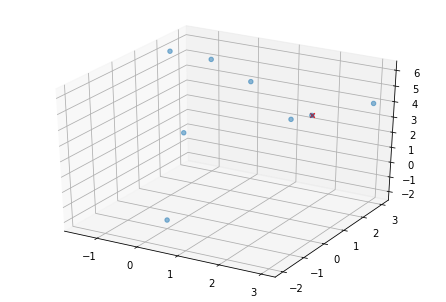

In [75]:
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter([X[0]], [X[1]], [X[2]], c='r', marker='x')
ax.scatter(candidates[:,0], candidates[:,1], candidates[:,2], alpha=0.5)
plt.show()